In [3]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set(font_scale = 2.5)
plt.rcParams['figure.figsize'] = (12, 9)

In [4]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [5]:
data = pd.read_excel("Data/Simulation Results/growth rates with test delays.xlsx", index_col = 0)
days_simulated = 25

In [6]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,test_delay_mean,0,1,...,15,16,17,18,19,20,21,22,23,24
0,0.224541,0.1,0.896516,1.909829,0.252475,False,0.172934,1.078622,5000,5011,...,67745,79663,93719,109816,128733,150106,174812,203321,236269,273680
1,0.244234,0.4,0.759919,1.554469,0.178340,False,0.094940,1.353151,5000,5011,...,78960,92976,109377,128204,149842,174765,202984,235093,272264,314621
2,0.231106,0.2,0.798786,2.025246,0.890702,False,0.219014,1.493677,5000,5001,...,10212,10374,10516,10660,10767,10851,10927,10997,11054,11100
3,0.250799,0.5,0.734837,2.420369,0.748940,False,0.209823,1.714701,5000,5011,...,15654,16265,16852,17395,17862,18344,18784,19191,19572,19938
4,0.237670,0.3,0.920458,1.826257,0.563240,False,0.433708,1.326534,5000,5004,...,27261,29529,31819,34147,36486,38852,41146,43536,45833,48282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.224541,0.1,0.704220,2.395308,0.657730,True,0.129625,1.369307,5000,5012,...,21858,23364,24948,26573,28194,29774,31409,33095,34842,36590
96,0.250799,0.5,0.804994,2.290237,0.524822,False,0.146342,1.421725,5000,5011,...,31175,33870,36536,39416,42303,45309,48363,51553,54837,58188
97,0.224541,0.1,0.772379,1.700372,0.511675,True,0.150993,1.074692,5000,5014,...,33626,37318,41195,45464,49955,54810,59805,65163,70949,77206
98,0.231106,0.2,0.892905,1.527444,0.740393,False,0.340446,1.218419,5000,5004,...,16627,17377,18148,18862,19540,20208,20807,21368,21892,22441


In [7]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

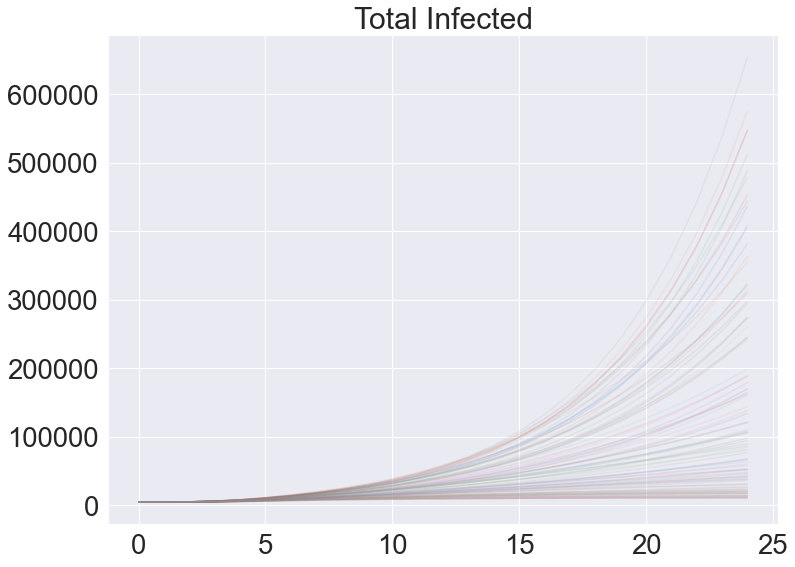

In [8]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

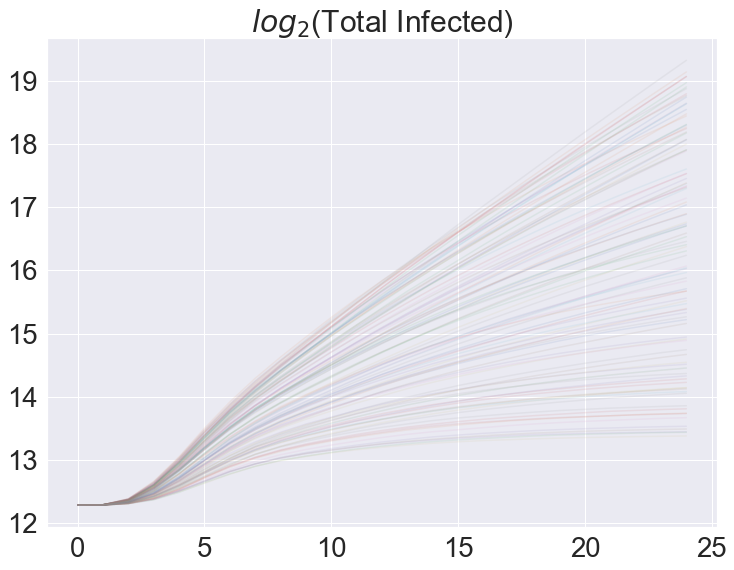

In [9]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

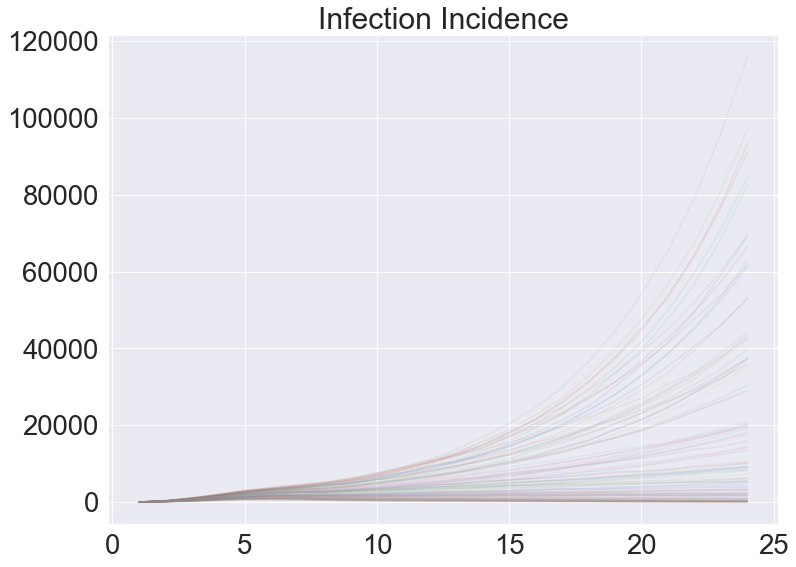

In [10]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

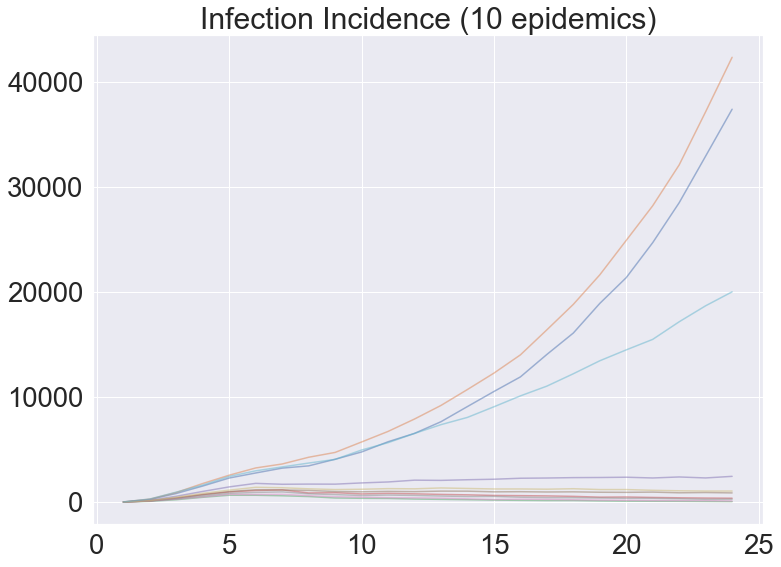

In [11]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

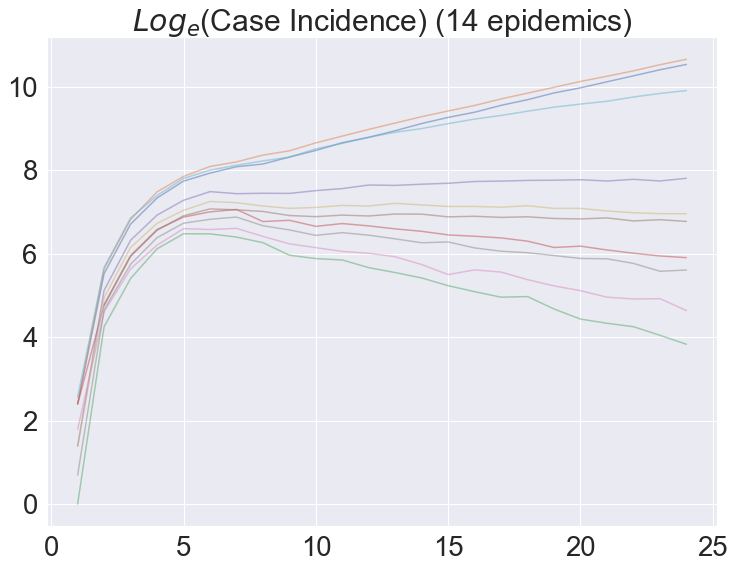

In [12]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
#plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [13]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1666.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.13e-15
Time:                        11:24:35   Log-Likelihood:                 27.984
No. Observations:                  15   AIC:                            -51.97
Df Residuals:                      13   BIC:                            -50.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6059      0.042    180.334      0.0

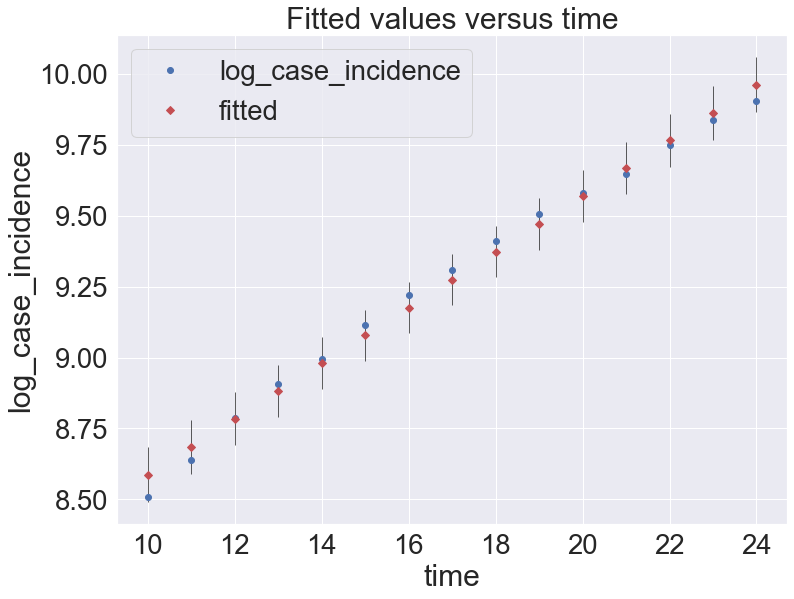

In [14]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [15]:
data_subset = infection_counts

In [16]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [17]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

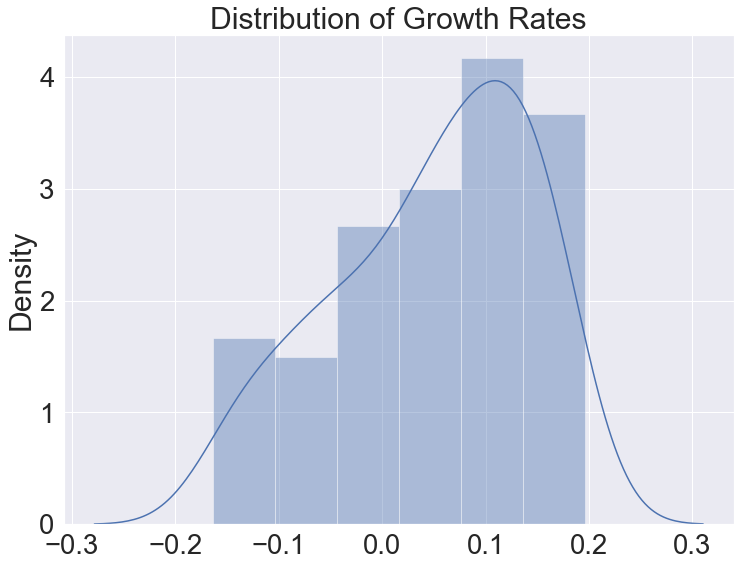

In [18]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [19]:
data_pars = data[data.columns[0:9]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

In [20]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,two_step_tracing,prob_has_trace_app,test_delay_mean,0,growth_rate
0,0.224541,0.1,0.896516,1.909829,0.252475,False,0.172934,1.078622,5000,0.145969
1,0.244234,0.4,0.759919,1.554469,0.178340,False,0.094940,1.353151,5000,0.141447
2,0.231106,0.2,0.798786,2.025246,0.890702,False,0.219014,1.493677,5000,-0.148621
3,0.250799,0.5,0.734837,2.420369,0.748940,False,0.209823,1.714701,5000,-0.062736
4,0.237670,0.3,0.920458,1.826257,0.563240,False,0.433708,1.326534,5000,0.016307
...,...,...,...,...,...,...,...,...,...,...
95,0.224541,0.1,0.704220,2.395308,0.657730,True,0.129625,1.369307,5000,0.015457
96,0.250799,0.5,0.804994,2.290237,0.524822,False,0.146342,1.421725,5000,0.028701
97,0.224541,0.1,0.772379,1.700372,0.511675,True,0.150993,1.074692,5000,0.067960
98,0.231106,0.2,0.892905,1.527444,0.740393,False,0.340446,1.218419,5000,-0.041564


                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1831.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           7.60e-99
Time:                        11:29:58   Log-Likelihood:                 365.12
No. Observations:                 100   AIC:                            -706.2
Df Residuals:                      88   BIC:                            -675.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

Text(0, 0.5, 'Halving / doubling times (days)')

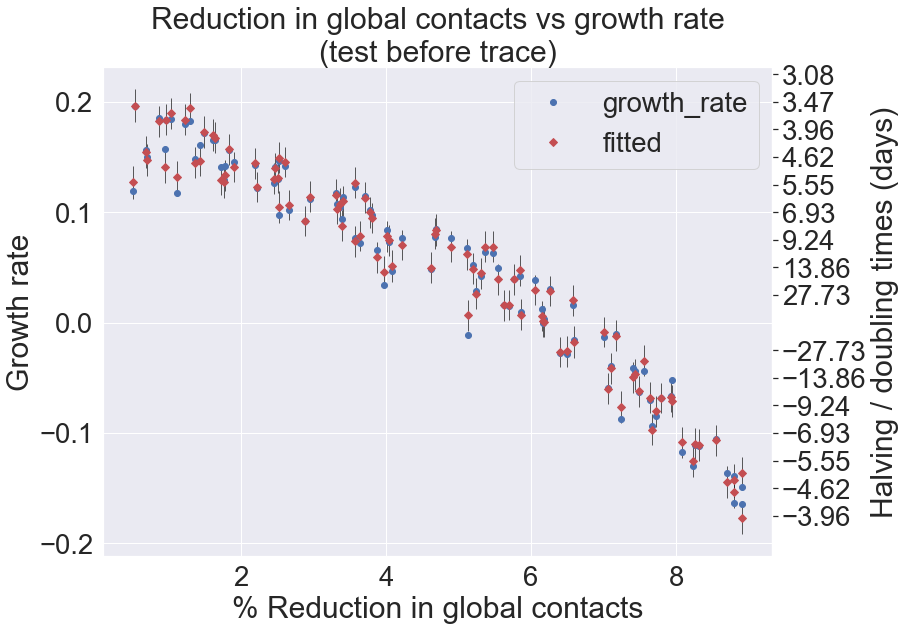

In [22]:
y, X = dmatrices('growth_rate ~ I(global_contact_reduction*10) + I(I(global_contact_reduction*10)**2) + I(I(global_contact_reduction*10)**3) + I(I(global_contact_reduction*10)**4)+ I(I(prob_has_trace_app*10)**2) +  I(contact_tracing_success_prob*10) + contact_trace_delay_par + I(infection_reporting_prob*10) + I(I(infection_reporting_prob*10)**2) + two_step_tracing + test_delay_mean', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

plot = sm.graphics.regressionplots.plot_fit(res, "I(global_contact_reduction * 10)", ax = ax)

y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.xlabel("% Reduction in global contacts")
plt.ylabel("Growth rate")
plt.title("Reduction in global contacts vs growth rate\n(test before trace)")
ax2.set_ylabel("Halving / doubling times (days)")

In [27]:
res.conf_int(alpha = 0.05)

array([[ 1.93305757e-01,  2.47337280e-01],
       [-1.34223224e-02, -7.78657443e-03],
       [-1.46267917e-02,  1.85413000e-02],
       [-1.70140474e-02, -3.62167578e-03],
       [ 4.72866226e-04,  2.55346266e-03],
       [-1.48175195e-04, -3.90567647e-05],
       [-4.69581876e-04, -8.79397228e-05],
       [-7.04804143e-03, -3.04721072e-03],
       [ 5.46077420e-03,  1.52936606e-02],
       [-2.55748157e-02, -1.55134683e-02],
       [ 4.81482702e-04,  2.12032572e-03],
       [ 9.16806914e-03,  1.84362267e-02]])

<AxesSubplot:xlabel='global_contact_reduction'>

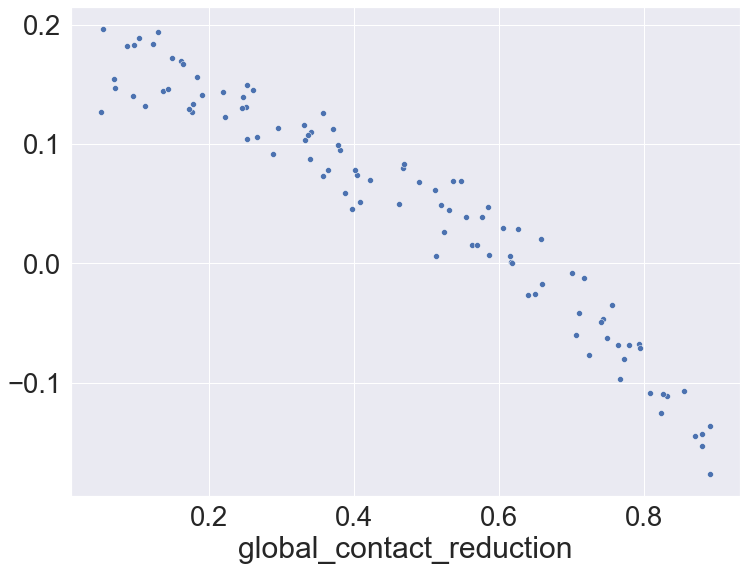

In [20]:
sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

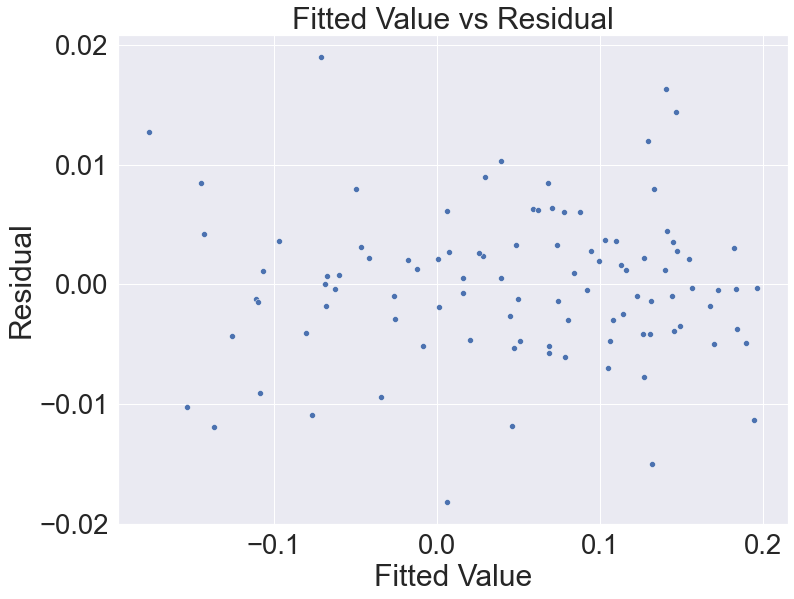

In [21]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

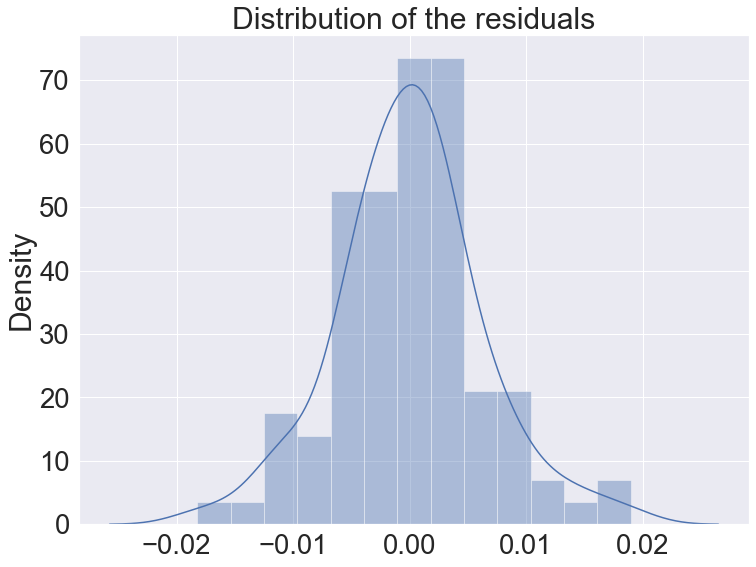

In [22]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

# Comparison to reference distribution

In [23]:
reference_coefs = pd.read_excel("Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**3,coef_contact_reduction**4
0,0.219887,-0.185921,-0.260727,0.422797,-0.414373


In [24]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**3"].loc[0]
beta_3 = reference_coefs["coef_contact_reduction**4"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3 +beta_3*x**4

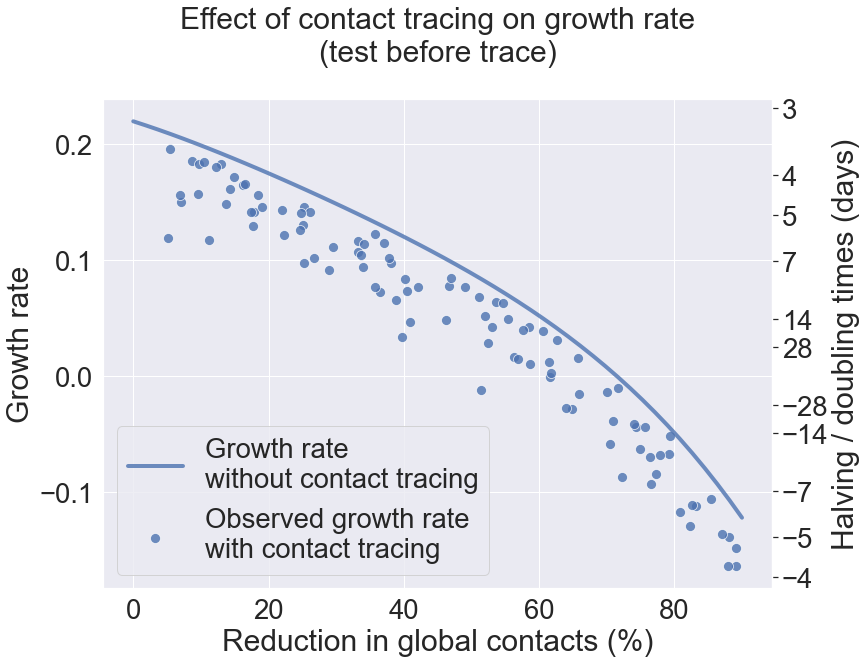

In [30]:

fig, ax = plt.subplots()

sns.scatterplot(data_pars["global_contact_reduction"] * 100, data_pars['growth_rate'], alpha = 0.8, s = 100)
plt.plot(x * 100, y, linewidth = 4, alpha = 0.8)

#y_vals = np.linspace(-0.175, 0.25, 18)
#y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

y_vals = [doubling_time_to_growth_rate(x) for x in [-3, -4, -5, -7, -14, -28, 28, 14, 7, 5, 4, 3]]

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)
plt.title("Effect of contact tracing on growth rate\n(test before trace)\n")
plt.ylabel("Growth rate")
plt.xlabel("Reduction in global contacts (%)")
ax2.set_ylabel("Halving / doubling times (days)")
plt.legend(("Growth rate\nwithout contact tracing", "Observed growth rate\nwith contact tracing"))
plt.savefig("Figures/Simulation - test delay/growth_rate_comparison.jpg", bbox_inches = 'tight')
plt.savefig("Figures/Simulation - test delay/growth_rate_comparison.png", bbox_inches = 'tight')
plt.savefig("Figures/Simulation - test delay/growth_rate_comparison.pdf", bbox_inches = 'tight')